In [112]:
# Compare Algorithms
import pandas
import numpy as np
import matplotlib.pyplot as plt

#import method releated to evaluation
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, StratifiedShuffleSplit, ShuffleSplit, cross_val_score, GridSearchCV

#metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

#export the models from the sklearn library
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
%matplotlib inline


# Toy Example: Handling Missing Values with sklearn's imputer methods
There are several built in methods within sklearn for filling in missing vaules; referred to as imputation.
Convinient way to do this is to use the Imputer class from scikitLearn. 
However note that it applies it to all columns. Later on we will see how we can use Pandas dataframe to control which columns to impute. 
Lets create a toy example to try these methods out.

In [121]:
from sklearn.preprocessing import Imputer
from io import StringIO

#first create some dummy data with missing values
csv_data =  '''A, B, C, D
1.0, 2.0, 3.0, 4.0
5.0, 6.0,,8.0
10.0, 11.0, 12.0,'''


df = pandas.read_csv(StringIO(csv_data))

#check that it has stored the NaN missing values
df.isnull().sum()

imr = Imputer(missing_values=np.nan, strategy = 'mean', axis = 0)
#imr = imr.fit(df)
#imputed_data = imr.transform(df.values)
imputed_data = imr.fit_transform(df.values)
imputed_data


array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

# Toy Example: Preparing categorical data and class labels for classifiers
Often classifiers expect that all values are numeric and that the class labels are provided as integers. 
If the original csv file does not follow this convention then we need to transform our data to suit the classifier. 
Next we will create a toy dataset to explore this in more detail.

In [122]:
df = pandas.DataFrame([
    ['green', 'M', 10.1, 'class1'],
    ['red', 'L', 13.5, 'class2'],
    ['blue', 'XL', 15.3, 'class1']
])

df.columns = ['colour', 'size', 'price', 'classLabels']

df


,colour,size,price,classLabels
0,green,M,10.1,class1
1,red,L,13.5,class2
2,blue,XL,15.3,class1


## Toy Example: Encoding class labels and mapping categorical features

There are many ways to acheive the mapping of categorical labels to integers. 



In [160]:
class_mapping = {label:idx for idx,label in enumerate(np.unique(df['classLabels']))}

class_mapping

#use the mapping dictionary to transform the class labels into integers

df['classLabels'] = df['classLabels'].map(class_mapping)
df

,colour,size,price,classLabels
0,green,M,10.1,0
1,red,L,13.5,1
2,blue,XL,15.3,0


An even more convinient way to create the feature transformation is to use the get_dummies methods 
implmented in pandas to generate one-hot-encodings.

In [161]:
df_new = pandas.get_dummies(df[['price', 'colour', 'size']])
#now append the class column on to this new frame
df_new['class'] = df.iloc[:, -1] 
df_new

,price,colour_blue,colour_green,colour_red,size_L,size_M,size_XL,class
0,10.1,0,1,0,0,1,0,0
1,13.5,0,0,1,1,0,0,1
2,15.3,1,0,0,0,0,1,0


# Toy Example:Exercise
Take a moment to study the transformed data. Can you understand how the binary valued columns represent the previous values?

## Diabetes Dataset : Prepare Dataset
We will use the Pima Indians diabetes dataset to explore the different evaluation methods provided in sklearn. 
It contains 768 rows and 9 features and is used to build models that can predict the onset of diabetes based on diagnostic measures.
Description of the features follow:

0 preg = Number of times pregnant

1 plas = Plasma glucose concentration a 2 hours in an oral glucose tolerance test

2 pres = Diastolic blood pressure (mm Hg)

3 skin = Triceps skin fold thickness (mm)

4 test = 2-Hour serum insulin (mu U/ml)

5 mass = Body mass index (weight in kg/(height in m)^2)

6 pedi = Diabetes pedigree function

7 age = Age (years)

8 class = Class variable (1:tested positive for diabetes, 0: tested negative for diabetes)"

All of the values in the file are numeric, specifically floating point values. 
We will learn how to load the file first, then use it with sklearn by dividing the data into class labels (Y) and feature sets (X). We dont need to split it into test/train as we are going to use scklearn methods to do that.

In [125]:
# load dataset
filename = "pima-indians-diabetes.data.csv"
#lets add some column names as the CSV file does not have these
names = ['pregnancies', 'glucose', 'bp', 'skin', 'insuline', 'bmi', 'pedi', 'age', 'class']
#lets use the convinient pandas library to read and form a data frame of our dataset
dataframe = pandas.read_csv(filename, names=names)

seed =100 #useful for random generators
print('first 5 rows')
dataframe.head()

first 5 rows


,pregnancies,glucose,bp,skin,insuline,bmi,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Exercise
Add a cell below and 
- use dataframe.isnull().sum() to check for null or missing values
- use dataframe.columns.values to view the names for this dataset i.e. 'pregnancies', 'glucose', 'bp', 'skin', 'insuline', 'bmi', 'pedi', 'age', 'class'
- use dataframe.hist(bins=50, figsize=(20,15)) with plt.show to explore its feature

# Unexpected Outliers
When analyzing the histogram we can identify that there are some outliers in some columns. We will further analyse those outliers and determine what we can do about them.

bp (Blood pressure) : By observing the data we can see that there are 0 values for blood pressure. And it is evident that the readings of the data set seems wrong because a living person cannot have diastolic blood pressure of zero. By observing the data we can see 35 counts where the value is 0.





In [126]:
print("Total zeros for BP feature: ", dataframe[dataframe.bp == 0].shape[0])
print(dataframe[dataframe.bp == 0].groupby('class')['age'].count())

Total zeros for BP feature:  35
class
0    19
1    16
Name: age, dtype: int64


# Exercise

The diabetes dataset which was set up with dataframe object has the following features = ['pregnancies', 'glucose', 'bp', 'skin', 'insuline', 'bmi', 'pedi', 'age', 'class']

Extending the example above we can execute the code below and explore the following column names:

glucose (Plasma glucose levels) : Even after fasting, glucose level should not be as low as zero. Therefor zero is an invalid reading. By observing the data can you identify if there are any rows where 'glocuse' column has a value of 0?


skin (Skin Fold Thickness) : For normal people skin fold thickness can’t be less than 10 mm better yet zero. Again check if there are any rows where value is 0?

bmi (Body Mass Index): Should not be 0 or close to zero unless the person is really underweight which could be life threatening.
Check for rows where value is 0?

insulin : In a rare situation a person can have zero insulin but by observing the data, again you should find if there are any values of zero in any rows?

# How do we handle invalid data / missing values ?

Option 1
Ignore/remove these instances : This is not actually possible in most cases because that would mean losing valuable information. And in this case “skin thickness” and “insulin” columns have a lot of invalid points. But it might work for “BMI”, “glucose ”and “blood pressure” data points.
To drop instances where an attribute is missing / invalid you can use:

dataframe.dropna(subset=["bp"]) # to get rid of instances where bp is missing

dataframe = dataframe[(dataframe.bp != 0) # to get rid of instances where bp is zero


Option 2
Set the values to an average/mean value : This might work for some data sets, but in our case putting a mean value to the blood pressure column would send a wrong signal to the model.
You can acheive this easily using the dataframe fillna() method for instance for the bp feature:

median = dataframe["bp"].median()

dataframe["bp"].fillna(media, inplace = True)

Optino 3
Avoid using features : It is possible to not use the features with a lot of invalid values for the model. This may work for “skin thickness” but its hard to predict that. We can do this easily with a dataframe for example as follows:

dataframe.drop("bp", axis=1) # axis=1 simply states to match the given column name to the column labels instead of an index

In this example we can clearly see that the dataset is incomplete in certain vaules. 
Since this is a demonstration for machine learning we will proceed with the given data with some minor adjustments.

- We will remove the rows which the bp (BloodPressure), bmi (BMI) and glucose (Glucose) are zero.

You can compare the changes to the dataframe in the next cell:

In [127]:
print('Print before cleaning : ', dataframe.shape)
dataframe = dataframe[(dataframe.bp != 0) & (dataframe.bmi != 0) & (dataframe.glucose != 0)]
print('Print before cleaning : ', dataframe.shape)

Print before cleaning :  (768, 9)
Print before cleaning :  (724, 9)


# Understanding your X (features) and y (labels) in datasets
When selecting the columnd from the data frame we need to understand the original source file (i.e. csv) file in order to specify which column forms the class label ; here if the patient is diabetic or not.

Normally the class label appears as the first column / features (as we saw in the MNIST dataset) or appears at the end , as with the diabetes dataset. 

This means that in the diabetes dataset, given that we have 9 columns; then the range of features to include in X will be 0:8 (from 0 upto and including 7) and class label index will be 8.

In [128]:
array = dataframe.values
# divide data into label and feature sets.
# this dataset has its class column in location 8
X = array[:,0:8] # upto column index 7 i.e. 0 to 7
y = array[:,8] # 8th column index

## Prepare models
We will use the scikitLearn library to access a bunch of ML models already avaiable
and run each of them on the diabetes classification dataset. 

For instance with a statement such as: 
models.append(('ANN', MLPClassifier()))

we are using sciktlearn's neural net classifier which is a Multi-layer Perceptron classifier. 

We will be using the default settings for each of the classifiers. 

We encourage you to look up the scikitlearn documentation on classifiers to understand the different hyper-parameter settings and how you might change them (http://scikit-learn.org/stable/)

In [129]:
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(kernel='rbf', gamma=0.7, C=1.0)))
models.append(('ANN', MLPClassifier()))


By evaluating our classifier performance on data that has been seen during training, we could get false confidence in the predictive power of our model. In the worst case, it may simply memorize the training samples but completely fails classifying new, similar samples -- we really don't want to put such a system into production!
Instead of using the same dataset for training and testing (this is called "resubstitution evaluation"), it is much much better to use a train/test split in order to estimate how well your trained model is doing on new data.

## Hold-out train-test splits

We need to split the data into training and testing. Luckily, this is a common pattern in machine learning and scikit-learn has a pre-built function to split data into training and testing sets for you. 
Here, we use 75% of the data as training, and 25% testing. 
Note that 80% and 20% is another common split, but there are no hard and fast rules. 
The most important thing is to fairly evaluate your system on data it has not seen during training!

In [131]:
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                                    train_size=0.75, test_size=0.25,
                                                    random_state=seed)
print("Labels for training and testing data")
print(train_X)
print(test_X)

Labels for training and testing data
[[1.00e+00 1.68e+02 8.80e+01 ... 3.50e+01 9.05e-01 5.20e+01]
 [7.00e+00 1.50e+02 7.80e+01 ... 3.52e+01 6.92e-01 5.40e+01]
 [5.00e+00 1.12e+02 6.60e+01 ... 3.78e+01 2.61e-01 4.10e+01]
 ...
 [2.00e+00 1.22e+02 5.20e+01 ... 3.62e+01 8.16e-01 2.80e+01]
 [2.00e+00 1.00e+02 6.80e+01 ... 3.85e+01 3.24e-01 2.60e+01]
 [7.00e+00 1.24e+02 7.00e+01 ... 2.55e+01 1.61e-01 3.70e+01]]
[[2.00e+00 9.00e+01 8.00e+01 ... 2.44e+01 2.49e-01 2.40e+01]
 [3.00e+00 1.73e+02 7.80e+01 ... 3.38e+01 9.70e-01 3.10e+01]
 [4.00e+00 9.00e+01 8.80e+01 ... 3.77e+01 3.62e-01 2.90e+01]
 ...
 [0.00e+00 1.02e+02 5.20e+01 ... 2.51e+01 7.80e-02 2.10e+01]
 [2.00e+00 9.10e+01 6.20e+01 ... 2.73e+01 5.25e-01 2.20e+01]
 [3.00e+00 7.80e+01 7.00e+01 ... 3.25e+01 2.70e-01 3.90e+01]]


**Tip: Stratified Split**
Especially for relatively small datasets, it's better to stratify the split. Stratification means that we maintain the original class proportion of the dataset in the test and training sets. For example, after we randomly split the dataset as shown in the previous code example, we have the following class proportions in percent:

In [132]:
#we will use the bincount function to count the total number of instances in each class
# using list to convert and cast the array as a list; so it works with bincount
print('All (class distribution):', np.bincount(list(map(float, y))) / float(len(y)) * 100.0)
print('Training (class distribution):', np.bincount(list(map(float,train_y))) / float(len(train_y)) * 100.0)
print('Test (class distribution):', np.bincount(list(map(float,test_y))) / float(len(test_y)) * 100.0)

All (class distribution): [65.60773481 34.39226519]
Training (class distribution): [63.90423573 36.09576427]
Test (class distribution): [70.71823204 29.28176796]


So, in order to stratify the split, we can pass the label array as an additional option to the `train_test_split` function, with stratify=True.

For more details about this function you should also look up http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [133]:
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                                    train_size=0.75, test_size=0.25,
                                                    random_state=seed,
                                                    stratify=y)

print('All (class distribution):', np.bincount(list(map(float, y))) / float(len(y)) * 100.0)
print('Training (class distribution):', np.bincount(list(map(float,train_y))) / float(len(train_y)) * 100.0)
print('Test (class distribution):', np.bincount(list(map(float,test_y))) / float(len(test_y)) * 100.0)

All (class distribution): [65.60773481 34.39226519]
Training (class distribution): [65.56169429 34.43830571]
Test (class distribution): [65.74585635 34.25414365]


# Bringing features onto same scale
We will use the built in sklearn methods to normalise the price column

In [138]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
mms = MinMaxScaler() # stdsc = StandardScaler()
train_X_norm = mms.fit_transform(train_X)
test_X_norm = mms.transform(test_X)
print(X_train_norm)

[[0.11764706 0.15483871 0.42222222 ... 0.03885481 0.0764304  0.03333333]
 [0.35294118 0.23225806 0.62222222 ... 0.44171779 0.04227156 0.11666667]
 [0.05882353 0.30322581 0.33333333 ... 0.14314928 0.06660974 0.03333333]
 ...
 [0.41176471 0.52258065 0.68888889 ... 0.39672802 0.09649872 0.5       ]
 [0.05882353 0.98064516 0.57777778 ... 0.37423313 0.34030743 0.13333333]
 [0.23529412 0.42580645 0.46666667 ... 0.2801636  0.16780529 0.13333333]]


## Train and test a model with the scikitlearn library methods, fit and predict

In [140]:
#lets work with the first classifier for now from the list above in the "Prepare models" setion
classifier = models[0][1]
classifier.fit(train_X_norm, train_y)
pred_y = classifier.predict(test_X_norm)

print("Classifier %s [Accuracy]:" % (models[0][0]))
print(np.sum(pred_y == test_y) / float(len(test_y)))

Classifier LR [Accuracy]:
0.7900552486187845


# Lets visualize the correct and failed predictions

In [142]:
#in the following code we use np.where 
#which is a handy command which is like asking 
#"tell me where in this array, entries satisfy a given condition".
#the [0] appended at the end simply extracts the first in a 2-element response
#you can delete the [0] and explore what the 2-d element looks like.

print('Samples correctly classified:')
correct_idx = np.where(pred_y == test_y)[0] 
print(correct_idx)

print('\nSamples incorrectly classified:')
incorrect_idx = np.where(pred_y != test_y)[0]
print(incorrect_idx)

Samples correctly classified:
[  0   2   3   6   7   9  10  11  12  13  14  15  16  17  18  19  20  21
  23  25  26  27  29  30  32  33  34  35  37  38  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  56  57  58  59  60  63  64  65
  66  68  70  71  72  73  74  75  76  77  79  82  83  84  86  87  88  90
  91  92  93  94  96  97  98  99 100 101 103 104 106 107 109 110 111 112
 113 115 116 117 118 119 121 124 125 126 127 128 129 132 133 134 135 136
 138 139 140 141 144 145 147 148 150 151 152 153 154 155 156 159 160 161
 162 163 164 165 166 167 168 169 170 172 173 174 175 176 177 178 179]

Samples incorrectly classified:
[  1   4   5   8  22  24  28  31  36  55  61  62  67  69  78  80  81  85
  89  95 102 105 108 114 120 122 123 130 131 137 142 143 146 149 157 158
 171 180]


In [141]:
idx = 2 # select an instance 

print("features of an instance that was incorrectly classified", idx, test_X_norm[idx], test_y[idx])


features of an instance that was incorrectly classified 2 [0.05882353 0.40645161 0.48888889 0.3015873  0.         0.16973415
 0.03714774 0.05      ] 0.0


## Use a scatter plot to visualise correct and incorrect classifications

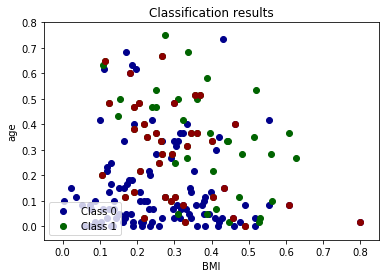

In [144]:
# Plot two dimensions
#lets select 2 features from our dataset
f1 = 5 # e.g. body mass index
f2 = 7 # e.g. the "age" feature

#set 2 colours for the two classes in the diabetes dataset
colors = ["darkblue", "darkgreen"]

#get the scatter data for correctly classified instance
#we use enumerate in our for loop
#It allows us to loop over something and have an automatic counter (here the counter is n)
#since our class values are 0 or 1 ; this works well here
for n, color in enumerate(colors):
    idx = np.where(test_y == n)[0]
    plt.scatter(test_X_norm[idx, f1], test_X_norm[idx, f2], color=color, label="Class %s" % str(n))

#get the scatter data for incorrectly classified instance
plt.scatter(test_X_norm[incorrect_idx, f1], test_X_norm[incorrect_idx, f2], color="darkred")

plt.xlabel('BMI')
plt.ylabel('age')
plt.legend(loc=3)
plt.title("Classification results")
plt.show()

We can also closely examine a few incorrectly classified instances (instead of all) using the scatter plot.
For instance say we want to print the true labels of 3 wrong predictions and modify the scatterplot code, which we used above, to visualize and distinguish just these three instances with different markers in the 2D scatterplot. 

Doing this allows us to understand prediction errors and in particular understand 
why our classifier made these wrong predictions

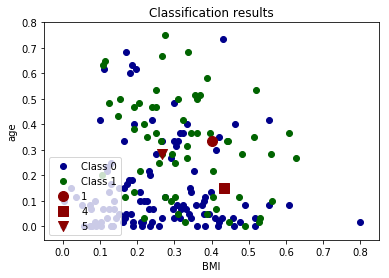

In [145]:
# Plot two dimensions
#lets select 2 features for from our dataset
f1 = 5 # body mass index
f2 = 7 # this is the "age" feature

#set 2 colours for the two classes in the diabetes dataset
colors = ["darkblue", "darkgreen"]

for n, color in enumerate(colors):
    idx = np.where(test_y == n)[0]
    plt.scatter(test_X_norm[idx, f1], test_X_norm[idx, f2],
                color=color, label="Class %s" % str(n))

# we use the zip function with 2 iterators
# iterate through the set of incorrect instance index, incorrect_idx and ['o', 's', 'v']
# zip will ensure that the iterator stops when shortest iterable is exhaused.
for i, marker in zip(incorrect_idx, ['o', 's', 'v']):
    plt.scatter(test_X_norm[i, f1], test_X_norm[i, f2],
                color="darkred",
                marker=marker, #specify the marker (see for a full list https://matplotlib.org/api/markers_api.html)
                s=100, # set the marker size
                label=i)

plt.xlabel('BMI')
plt.ylabel('age')
plt.legend(loc=3)
plt.title("Classification results")
plt.show()


### Exercise 
- How can you modify the code above to choose specfic indexes of incorrectly classified instances?
- Try generating the plots for different models?
- You can use a similar analysis on a different dataset such as the Iris dataset. You can load Iris dataset which is part of the sklearn library "from sklearn.datasets import load_iris". Thereafter 
                    iris = load_iris()

                    X, y = iris.data, iris.target

                    class_names = iris.target_names

                    print("Number of instances: ", len(X))

Examine its columns and consider how to normalise them if needed.